# Assignment 2

Akos Engelmann, Simon Jasansky

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# we don't need to load the y_train and y_test, as we will not use the labels of the image
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

In [3]:
# split the test data into test and validation
data = np.concatenate((x_train, x_test))
print(data.shape)
# the shape is as expected, 60000 samples with 32x32 pictures, with 3 layers (RGB)

(60000, 32, 32, 3)


(32, 32, 3)
(32, 3)
(3,)
[59 62 63]


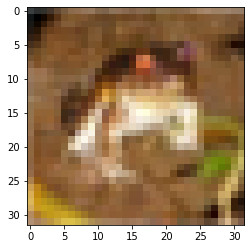

In [4]:
# first picture
print(data[0].shape)

# first row (or column, idk) of pixels of the picture
print(data[0][0].shape)

# first pixel of the first row/column of the picture (RGB values)
print(data[0][0][0].shape)
print(data[0][0][0])

# print the first picture
plt.imshow(data[0])
plt.show()

In [5]:
# do normalization over each image (use L2 norm)
data = data.astype("float32")
data = tf.keras.utils.normalize(data, axis = 1, order = 2)

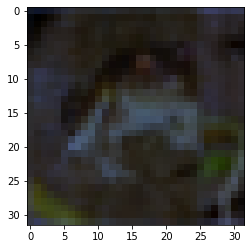

In [6]:
# print the first picture again (normalized)
plt.imshow(data[0])
plt.show()

In [7]:
# reshuffle before splitting data
np.random.shuffle(data)

# split into train, test and validation sets
train = data[:48000]
test = data[48000:54000]
valid = data[54000:]

print(train.shape)
print(test.shape)
print(valid.shape)

(48000, 32, 32, 3)
(6000, 32, 32, 3)
(6000, 32, 32, 3)


In [15]:
# implement CAE
input_layer = tf.keras.layers.Input(shape=(32, 32, 3), name="INPUT")
# shape now: 32x32x3

x = tf.keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(input_layer)
# shape now: 32x32x8

x = tf.keras.layers.MaxPooling2D((2, 2))(x)
#shape now: 16x16x8

x = tf.keras.layers.Conv2D(filters = 12, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(x)
#shape now: 16x16x8


latent_space_rep = tf.keras.layers.MaxPooling2D((2, 2), name = "LATENT_SPACE")(x)
#shape now: 8x8x16

x = tf.keras.layers.UpSampling2D((2, 2))(latent_space_rep)
# shape now: 16x16x16

x = tf.keras.layers.Conv2DTranspose(12, (3, 3), activation='relu', padding='same')(x)
# shape now: 16x16x12

x = tf.keras.layers.UpSampling2D((2, 2))(x)
# shape now: 32x32x12

output_layer = tf.keras.layers.Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)
# shape now: 32x32x3

In [16]:
pic_CAE = tf.keras.models.Model(input_layer, output_layer)
pic_CAE.compile(optimizer='adam', loss='mse')
pic_CAE.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 12)        876       
_________________________________________________________________
LATENT_SPACE (MaxPooling2D)  (None, 8, 8, 12)          0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 16, 16, 12)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 12)       

In [17]:
# train the model
pic_CAE.fit(train, train,
           epochs=10,
           batch_size=128,
           shuffle=True,
           validation_data=(test, test))

Epoch 1/10
375/375 [==============================] - 52s 139ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 2/10
375/375 [==============================] - 45s 121ms/step - loss: 0.0010 - val_loss: 9.2655e-04
Epoch 3/10
375/375 [==============================] - 45s 120ms/step - loss: 8.9516e-04 - val_loss: 8.5305e-04
Epoch 4/10
375/375 [==============================] - 47s 126ms/step - loss: 8.4069e-04 - val_loss: 8.1323e-04
Epoch 5/10
375/375 [==============================] - 45s 120ms/step - loss: 8.0651e-04 - val_loss: 7.8493e-04
Epoch 6/10
375/375 [==============================] - 46s 122ms/step - loss: 7.7995e-04 - val_loss: 7.6362e-04
Epoch 7/10
375/375 [==============================] - 49s 131ms/step - loss: 7.5928e-04 - val_loss: 7.4531e-04
Epoch 8/10
375/375 [==============================] - 47s 126ms/step - loss: 7.4167e-04 - val_loss: 7.2825e-04
Epoch 9/10
375/375 [==============================] - 45s 120ms/step - loss: 7.2860e-04 - val_loss: 7.1417e-04
Epoch 10/10
3

In [19]:
 pic_CAE.save("pic_cae.h5")

In [22]:
# make model to get intermediate representation in latent space
get_encoded_pic = tf.keras.models.Model(inputs=pic_CAE.input, outputs=pic_CAE.get_layer("LATENT_SPACE").output)

In [23]:
# get the intermediate pictures
encoded_pic = get_encoded_pic.predict(test)
encoded_pic = encoded_pic.reshape((len(test), 8*8*12))
encoded_pic.shape

(6000, 768)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


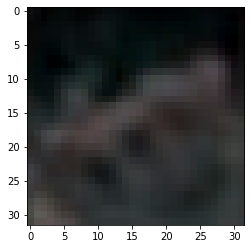

In [24]:
# get the reconstructed pics and visualize them
reconstructed_pics = pic_CAE.predict(test)

plt.imshow(reconstructed_pics[0])
plt.show()